In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_engine import DataSet
import tensorflow as tf
import gpflow
import warnings

warnings.filterwarnings('ignore')

C:\Users\aksha\Desktop\python\FX_Volatility\.venv\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
data = DataSet(datafile="EURUSD30_formatted.csv")

In [3]:
data.training_data[0]

array([-0.52979011, -0.52979011, -0.52979011, -0.52979011, -0.52979011,
       -0.52979011, -0.52979011, -0.52979011, -0.52979011, -0.36211438,
       -0.3528488 , -0.36201416, -0.36094097, -0.36099896, -0.3807988 ,
       -0.40132307, -0.42868033, -0.43712841, -0.4754446 , -0.5017136 ,
       -0.51094507, -0.51098502, -0.50657895, -0.51305224, -0.5139908 ,
       -0.43530697, -0.4296511 , -0.42859164, -0.42863158, -0.41363648,
       -0.41321931, -0.41310855, -0.41848939, -0.42071028, -0.40012571,
       -0.46711529, -0.47248646, -0.46722138, -0.42800963, -0.3388894 ,
       -0.30222415, -0.27797096, -0.26652969, -0.26827866, -0.2899492 ,
       -0.26244668, -0.25235955, -0.25868511, -0.27804367, -0.19086705])

In [4]:
data.test_data[0]

array([-0.21991794, -0.24281443, -0.25457511, -0.24222862, -0.24131769,
       -0.27925131, -0.28942681, -0.287372  , -0.30637492, -0.49697259])

In [5]:
X = tf.convert_to_tensor(np.arange(0, 50).reshape(-1, 1), dtype=tf.float64)
Y = tf.convert_to_tensor(data.training_data[1].reshape(-1, 1), dtype=tf.float64)
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.Matern32()
)

In [6]:
optim = gpflow.optimizers.Scipy()
optim.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -87.25999333653752
        x: [ 1.926e+01 -1.511e+00 -7.809e+00]
      nit: 30
      jac: [ 3.511e-07 -6.393e-07 -1.129e-05]
     nfev: 43
     njev: 43
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [7]:
X_new = tf.convert_to_tensor(np.arange(50, 60).reshape(-1, 1), dtype=tf.float64)

In [8]:
X_tot = tf.convert_to_tensor(np.arange(0, 60).reshape(-1, 1), dtype=tf.float64)
f_mean, f_var = model.predict_f(X_tot)

In [9]:
f_std = np.sqrt(np.array(f_var))
lower_interval = np.array(f_mean)-(2*f_std)
upper_interval = np.array(f_mean)+(2*f_std)

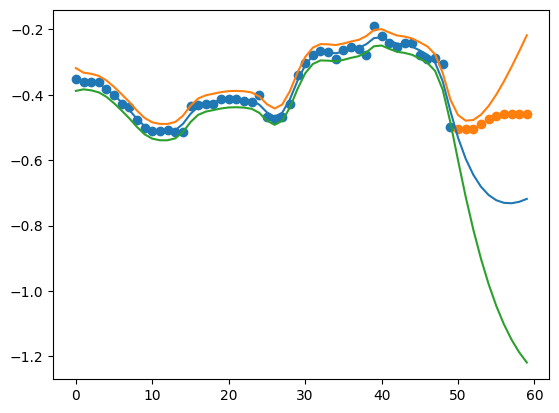

In [10]:
plt.scatter(np.arange(0,50), data.training_data[1])
plt.scatter(np.arange(50,60), data.test_data[1])
plt.plot(np.arange(0,60), np.array(f_mean))
plt.plot(np.arange(0,60), upper_interval)
plt.plot(np.arange(0,60), lower_interval)

In [103]:
loss = np.sum(np.abs(np.array(f_mean)-data.test_data[1]))
loss

39.659331883686136

In [18]:
next_set = tf.convert_to_tensor(np.arange(60, 110).reshape(-1, 1), dtype=tf.float64)
for_next_time, _ = model.predict_f(next_set)

In [19]:
class UpdatedMeanFunction(gpflow.functions.MeanFunction):

    def __init__(self, data, start):
        super().__init__()
        self.data = data
        self.start = start

    def __call__(self, X):
        return self.data[X-start]

In [21]:
model.mean_function = UpdatedMeanFunction(data=for_next_time, start=60)

## Final program flow

In [91]:
class UpdatedMeanFunction(gpflow.functions.MeanFunction):

    def __init__(self, data, start):
        super().__init__()
        self.data = data
        self.start = start

    def __call__(self, X):
        return tf.gather(self.data, tf.cast(X, dtype=tf.int64)-self.start)

In [92]:
data = DataSet(datafile="EURUSD30_formatted.csv")

In [93]:
X_predictions, Y_predictions, lower_std, upper_std = [], [], [], []

Constructing for 0th data entry

In [98]:
X = tf.convert_to_tensor(np.arange(0, 50).reshape(-1, 1), dtype=tf.float64)
Y = tf.convert_to_tensor(data.training_data[0].reshape(-1, 1), dtype=tf.float64)
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.Matern32()
)
optim = gpflow.optimizers.Scipy()
optim.minimize(model.training_loss, model.trainable_variables)
X_new = tf.convert_to_tensor(np.arange(50, 60).reshape(-1, 1), dtype=tf.float64)
f_mean, f_var = model.predict_f(X_new)
X_predictions.append(X_new)
Y_predictions.append(f_mean)
lower_std.append(f_mean-f_var)
upper_std.append(f_mean+f_var)

In [99]:
def construct_new_model(index, old_model):
    X_next = tf.convert_to_tensor(np.arange((10*index), (10*index)+60).reshape(-1, 1), dtype=tf.float64)
    Y_next = tf.convert_to_tensor(data.training_data[1].reshape(-1, 1), dtype=tf.float64)
    mean_f, _ = old_model.predict_f(X_next)
    new_model = gpflow.models.GPR(
        (X_next, Y_next),
        kernel=gpflow.kernels.Matern32(),
        mean_function=UpdatedMeanFunction(data=mean_f, start=(10*i))
    )
    return new_model

In [100]:
for i in range(1,2):
    current_model = construct_new_model(i, model)
    X_new = tf.convert_to_tensor(np.arange((10*i)+50, (10*i)+60).reshape(-1, 1), dtype=tf.float64)
    f_mean, f_var = current_model.predict_f(X_new)

ShapeMismatchError: 
Tensor shape mismatch.
  Function: GPR_deprecated.__init__
    Declared: C:\Users\aksha\Desktop\python\FX_Volatility\.venv\Lib\site-packages\gpflow\models\gpr.py:59
    Argument: data
      Index: [0]
        Expected: [N, D]
        Actual:   [60, 1]
      Index: [1]
        Expected: [N, P]
        Actual:   [50, 1]
    Argument: noise_variance
      Expected: []
      Actual:   <Tensor is None or has unknown shape>
